# Simulación de ceniza volcánica: Modelo 3D y mapa de riesgo

## 1. Contexto y objetivos
En el notebook anterior (`01_prototipo_2D.ipynb`), desarrollamos un modelo físico funcional en 2D que simula la altura y distancia de las partículas (Vista de perfil).
Sin embargo, para evaluar el **riesgo volcánico real**, necesitamos responder: ¿Qué ciudades o zonas geográficas serán afectadas?

Este notebook expande la simulación a 3 Dimensiones ($x, y, z$) para obtener una vista aérea de la dispersión.

## 2. Cambios en el modelo físico
La física subyacente (Advección-Difusión) permanece idéntica, pero vectorizamos las ecuaciones para manejar tres coordenadas:
* **Eje $x$ (Longitudinal):** Dirección principal del viento (Este-Oeste).
* **Eje $y$ (Vertical):** Altura de la columna eruptiva y caída por gravedad.
* **Eje $z$ (Transversal):** Dispersión lateral (Norte-Sur).

### Ecuación Vectorial 3D
El estado de cada partícula ahora está definido por un vector $\vec{r} = (x, y, z)$. La evolución sigue la ecuación de Langevin:

$$\vec{r}_{t+1} = \vec{r}_t + \underbrace{\vec{V}(y) \cdot \Delta t}_{\text{Viento + Gravedad}} + \underbrace{\sqrt{2D\Delta t} \cdot \vec{\xi}}_{\text{Difusión Isotrópica}}$$

**Nota sobre la difusión en $z$:**
Aunque asumiremos inicialmente que el viento en $z$ es cero ($v_z = 0$), la nube se ensanchará lateralmente debido al término estocástico ($\vec{\xi}$). Esto simula cómo la turbulencia atmosférica dispersa la ceniza en todas direcciones, creando una forma de "abanico" o pluma cónica vista desde arriba.

### 3. Escala realista
A diferencia del prototipo anterior, aquí simularemos una erupción a escala real:
* **Distancias:** Kilómetros (no metros).
* **Masa:** Toneladas de ceniza.
* **Tiempo:** Horas de erupción.

El objetivo final es transformar puntos dispersos en un **mapa de riesgo** interpretable para la toma de decisiones.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib import colors

# --- 1. CONFIGURACIÓN DE ESCENARIO REALISTA ---
# Simularemos una erupción moderada (VEI 3)
N_PARTICULAS = 30000      # Alta resolución
DT = 10.0                 # Paso de tiempo (segundos)
TIEMPO_VUELO_HORAS = 3    # Tiempo total de simulación
TIEMPO_PASOS = int(TIEMPO_VUELO_HORAS * 3600 / DT)

# Parámetros Físicos
MASA_ERUPCION_KG = 5.0e8  # 500 Millones de kg (0.5 Megatoneladas)
ALTURA_COLUMNA = 6000.0   # 6 km de altura
D = 400.0                 # Difusión (Turbulencia atmosférica a gran escala)

# Inicialización
# Todas las partículas salen de (0, Altura, 0)
posiciones = np.zeros((N_PARTICULAS, 3))
posiciones[:, 1] = ALTURA_COLUMNA 

# Emisión continua: Las partículas salen a lo largo de la primera hora
tiempos_nacimiento = np.linspace(0, 3600, N_PARTICULAS) 
en_suelo = np.zeros(N_PARTICULAS, dtype=bool)

# --- 2. BUCLE DE SIMULACIÓN (Langevin 3D) ---
print(f"Simulando {TIEMPO_VUELO_HORAS} horas de dispersión con {N_PARTICULAS} partículas...")

for t in range(TIEMPO_PASOS):
    t_actual = t * DT
    
    # Solo movemos las que ya nacieron y siguen en el aire
    vuelan = (tiempos_nacimiento <= t_actual) & (~en_suelo)
    
    if np.sum(vuelan) > 0:
        coords = posiciones[vuelan]
        
        # A. VIENTO (Advección)
        # Viento fuerte del Oeste (25 m/s = 90 km/h)
        vx = np.full(len(coords), 25.0) 
        # Caída gravitatoria (~2 m/s para ceniza gruesa)
        vy = np.full(len(coords), -2.0)
        # Sin viento lateral (solo difusión)
        vz = np.zeros(len(coords))
        
        desplazamiento = np.column_stack((vx, vy, vz)) * DT
        
        # B. TURBULENCIA (Difusión)
        ruido = np.random.normal(0, np.sqrt(2 * D * DT), size=coords.shape)
        
        # C. INTEGRACIÓN
        posiciones[vuelan] += desplazamiento + ruido
        
        # D. SUELO (Condición de Frontera)
        # Si y <= 0, se quedan en el suelo
        suelo_mask = (posiciones[:, 1] <= 0) & vuelan
        posiciones[suelo_mask, 1] = 0.0
        en_suelo[suelo_mask] = True

print("¡Simulación terminada!")

Simulando 3 horas de dispersión con 30000 partículas...
¡Simulación terminada!


In [16]:
# --- 3. PROCESAMIENTO: DE PUNTOS A DENSIDAD ---

# Filtramos solo la ceniza depositada
x_suelo = posiciones[en_suelo, 0]
z_suelo = posiciones[en_suelo, 2]

# Definimos el área geográfica del mapa (en Metros)
# 100 km al Este, 20 km Norte/Sur
RANGO_X = [0, 100000]     
RANGO_Z = [-20000, 20000] 
RESOLUCION = 100 # Número de celdas (bins)

# Creamos el Histograma 2D (Conteo de partículas)
conteo, xedges, yedges = np.histogram2d(
    x_suelo, z_suelo, bins=RESOLUCION, range=[RANGO_X, RANGO_Z]
)

# CÁLCULO FÍSICO DE MASA
# 1. ¿Cuánto pesa cada partícula simulada?
masa_por_particula = MASA_ERUPCION_KG / N_PARTICULAS

# 2. ¿Cuánto mide cada celda del mapa en la realidad? (m^2)
ancho_celda_x = (RANGO_X[1] - RANGO_X[0]) / RESOLUCION
ancho_celda_z = (RANGO_Z[1] - RANGO_Z[0]) / RESOLUCION
area_celda_m2 = ancho_celda_x * ancho_celda_z

# 3. Matriz de Carga (Load) en kg/m^2
# (Partículas en celda * Peso partícula) / Área celda
carga_ceniza = (conteo * masa_por_particula) / area_celda_m2

# 4. Suavizado (Para realismo continuo)
mapa_suave = gaussian_filter(carga_ceniza, sigma=1.5)

print(f"Carga Máxima registrada: {np.max(mapa_suave):.2f} kg/m^2")

Carga Máxima registrada: 2.86 kg/m^2


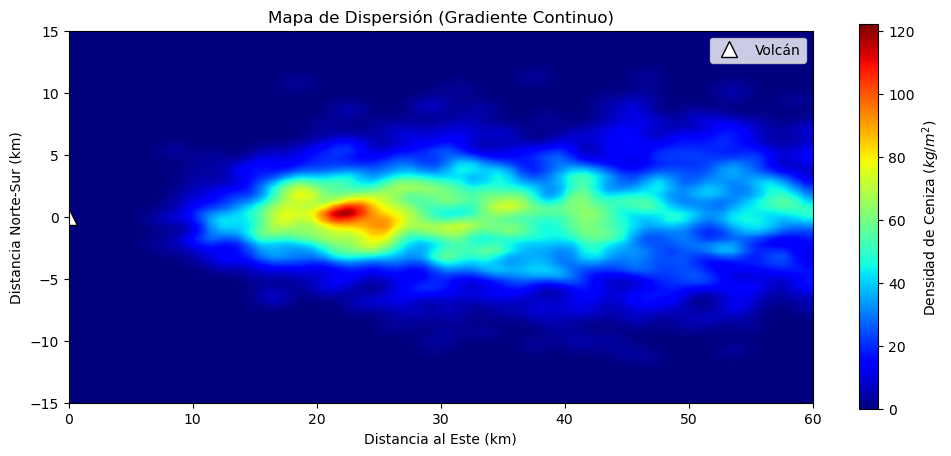

In [26]:
# --- VISUALIZACIÓN A: MAPA DE CALOR CONTINUO ---
# Objetivo: Ver la distribución geográfica y la dirección de la pluma.

plt.figure(figsize=(12, 5))

# Usamos 'plasma' o 'inferno' para un look científico de alta intensidad
plt.imshow(mapa_suave.T, origin='lower', cmap='jet', interpolation='gaussian',
           extent=[RANGO_X[0]/1000, RANGO_X[1]/1000, RANGO_Z[0]/1000, RANGO_Z[1]/1000])

plt.colorbar(label='Densidad de Ceniza ($kg/m^2$)')
plt.plot(0, 0, 'w^', markersize=12, markeredgecolor='k', label='Volcán')

plt.title("Mapa de Dispersión (Gradiente Continuo)")
plt.xlabel("Distancia al Este (km)")
plt.ylabel("Distancia Norte-Sur (km)")
plt.legend()
plt.grid(False)
plt.show()

## 3. Clasificación del Riesgo (Impacto Real)

El mapa anterior nos muestra *dónde* hay ceniza, pero no nos dice qué tan grave es. En gestión de riesgos, se utlizan umbrales específicos para tomar decisiones.

Basándonos en estándares vulcanológicos (ej. USGS), clasificamos la acumulación en **4 Zonas de Impacto**:

| Zona (Color) | Carga ($kg/m^2$) | Impacto Esperado |
| :--- | :--- | :--- |
| **Verde** | 1 - 10 | **Molestia:** Aeropuertos cerrados, limpieza necesaria. |
| **Amarillo** | 10 - 100 | **Daño Económico:** Pérdida de cultivos, daño a motores. |
| **Naranja** | 100 - 300 | **Daño Estructural:** Riesgo para techos débiles. |
| **Rojo** | > 300 | **Colapso:** Destrucción de techos, peligro mortal. |

A continuación, convertimos nuestro gradiente continuo en un **Mapa de Zonas Discretas**.

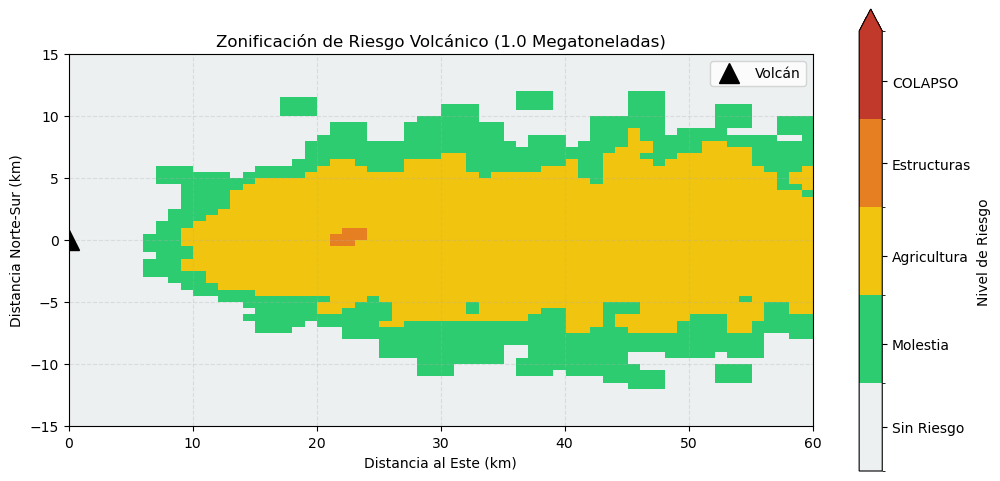

In [25]:
# --- VISUALIZACIÓN B: MAPA DE RIESGO CLASIFICADO ---
# Objetivo: Identificar zonas de acción inmediata.

plt.figure(figsize=(12, 6))

# 1. Definir los niveles y colores estándar
niveles = [0, 1, 10, 100, 300, 1000] # Los cortes de la tabla
colores_riesgo = ['#ecf0f1', '#2ecc71', '#f1c40f', '#e67e22', '#c0392b'] 
# (Gris, Verde, Amarillo, Naranja, Rojo)

# 2. Crear el mapa de color discreto (BoundaryNorm)
cmap_custom = colors.ListedColormap(colores_riesgo)
norma = colors.BoundaryNorm(niveles, cmap_custom.N)

# 3. Graficar
plt.imshow(mapa_suave.T, origin='lower', interpolation='nearest', # 'nearest' para ver los bordes de zona claros
           extent=[RANGO_X[0]/1000, RANGO_X[1]/1000, RANGO_Z[0]/1000, RANGO_Z[1]/1000],
           cmap=cmap_custom, norm=norma)

# 4. Barra de color explicativa
cbar = plt.colorbar(label='Nivel de Riesgo', extend='max')
cbar.set_ticks([0.5, 5, 50, 200, 600]) # Ubicación de etiquetas
cbar.set_ticklabels(['Sin Riesgo', 'Molestia', 'Agricultura', 'Estructuras', 'COLAPSO'])

plt.plot(0, 0, 'k^', markersize=15, label='Volcán')
plt.title(f"Zonificación de Riesgo Volcánico ({MASA_ERUPCION_KG/1e9} Megatoneladas)")
plt.xlabel("Distancia al Este (km)")
plt.ylabel("Distancia Norte-Sur (km)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.show()

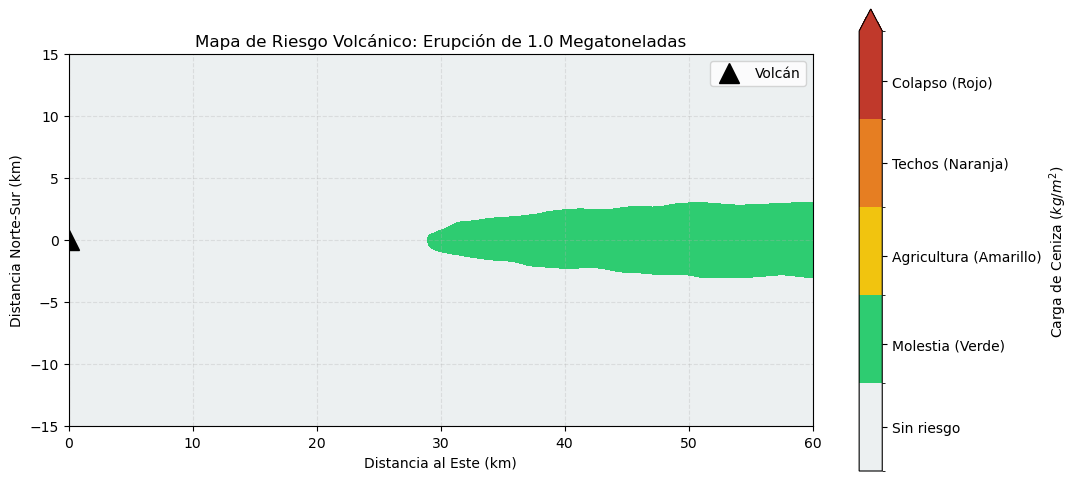

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.ndimage import gaussian_filter

# --- 1. CONFIGURACIÓN "REALISTA" (Erupción Moderada) ---
N_PARTICULAS = 20000      # Aumentamos para tener mejor resolución
DT = 5.0                  # Pasos de 5 segundos
TIEMPO_TOTAL_HORAS = 2    # Simulamos 2 horas de vuelo
TIEMPO_PASOS = int(TIEMPO_TOTAL_HORAS * 3600 / DT)

# Parámetros Físicos
MASA_ERUPCION_KG = 1.0e9  # 1 Millón de Toneladas (Erupción VEI 3 pequeña)
ALTURA_COLUMNA = 5000.0   # 5 km de altura
D = 500.0                 # Difusión atmosférica (m^2/s) - Más turbulencia a gran escala

# Posición Inicial (Todas salen del volcán en 0,0,5000)
posiciones = np.zeros((N_PARTICULAS, 3))
posiciones[:, 1] = ALTURA_COLUMNA 
tiempos_nacimiento = np.linspace(0, 3600, N_PARTICULAS) # La erupción dura 1 hora emitiendo
en_suelo = np.zeros(N_PARTICULAS, dtype=bool)

# --- 2. MOTOR FÍSICO (Advección-Difusión) ---
for t in range(TIEMPO_PASOS):
    t_actual = t * DT
    
    # Filtro de activas
    vuelan = (tiempos_nacimiento <= t_actual) & (~en_suelo)
    if np.sum(vuelan) == 0: continue
    
    coords = posiciones[vuelan]
    
    # PERFIL DE VIENTO REALISTA (Westerly Wind)
    # Viento fuerte en altura (20 m/s = 72 km/h) hacia el Este (X)
    velocidad_viento = 20.0 
    vx = np.full(len(coords), velocidad_viento)
    
    # Velocidad de caída (Ley de Stokes simplificada para partículas medias)
    # Caen a ~1 m/s
    vy = np.full(len(coords), -1.5)
    
    # Viento cruzado (z) nulo, solo difusión
    vz = np.zeros(len(coords))
    
    desplazamiento = np.column_stack((vx, vy, vz)) * DT
    
    # Difusión (Turbulencia)
    ruido = np.random.normal(0, np.sqrt(2 * D * DT), size=coords.shape)
    
    # Actualizar posición
    posiciones[vuelan] += desplazamiento + ruido
    
    # Chequeo de suelo
    suelo_mask = (posiciones[:, 1] <= 0) & vuelan
    posiciones[suelo_mask, 1] = 0.0
    en_suelo[suelo_mask] = True

# --- 3. PROCESAMIENTO DE DATOS (Mapas de Riesgo) ---
x_suelo = posiciones[en_suelo, 0]
z_suelo = posiciones[en_suelo, 2]

# Definimos el área del mapa (50 km x 20 km)
RANGO_X = [0, 60000]     # 60 km al Este
RANGO_Z = [-15000, 15000] # 15 km Norte/Sur
BINS = 100 # Resolución del mapa

# Histograma 2D
heatmap, xedges, yedges = np.histogram2d(
    x_suelo, z_suelo, bins=BINS, range=[RANGO_X, RANGO_Z]
)

# Cálculo de Masa por Área
area_celda_m2 = ((RANGO_X[1]-RANGO_X[0])/BINS) * ((RANGO_Z[1]-RANGO_Z[0])/BINS)
masa_por_particula = MASA_ERUPCION_KG / N_PARTICULAS
kg_por_celda = heatmap * masa_por_particula
kg_m2 = kg_por_celda / area_celda_m2  # ESTO ES LO IMPORTANTE: kg/m^2

# Suavizado para realismo
mapa_final = gaussian_filter(kg_m2, sigma=1.5)

# --- 4. VISUALIZACIÓN PROFESIONAL POR NIVELES ---
plt.figure(figsize=(12, 6))

# Definimos los colores CIENTÍFICOS
# Niveles: 0, 1 (Molestia), 10 (Daño), 100 (Estructural), 300+ (Colapso)
niveles = [0, 1, 10, 100, 300, 1000]
colores = ['#ecf0f1', '#2ecc71', '#f1c40f', '#e67e22', '#c0392b'] # Gris, Verde, Amarillo, Naranja, Rojo
cmap_riesgo = colors.ListedColormap(colores)
norma = colors.BoundaryNorm(niveles, cmap_riesgo.N)

# Dibujamos en Kilómetros para que sea legible
plt.imshow(mapa_final.T, interpolation='gaussian', origin='lower',
           extent=[RANGO_X[0]/1000, RANGO_X[1]/1000, RANGO_Z[0]/1000, RANGO_Z[1]/1000],
           cmap=cmap_riesgo, norm=norma)

cbar = plt.colorbar(label='Carga de Ceniza ($kg/m^2$)', extend='max')
cbar.set_ticks([0.5, 5, 50, 200, 600]) # Posición visual de las etiquetas
cbar.set_ticklabels(['Sin riesgo', 'Molestia (Verde)', 'Agricultura (Amarillo)', 'Techos (Naranja)', 'Colapso (Rojo)'])

plt.plot(0, 0, 'k^', markersize=15, label='Volcán')
plt.title(f"Mapa de Riesgo Volcánico: Erupción de {MASA_ERUPCION_KG/1e9} Megatoneladas")
plt.xlabel("Distancia al Este (km)")
plt.ylabel("Distancia Norte-Sur (km)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.show()

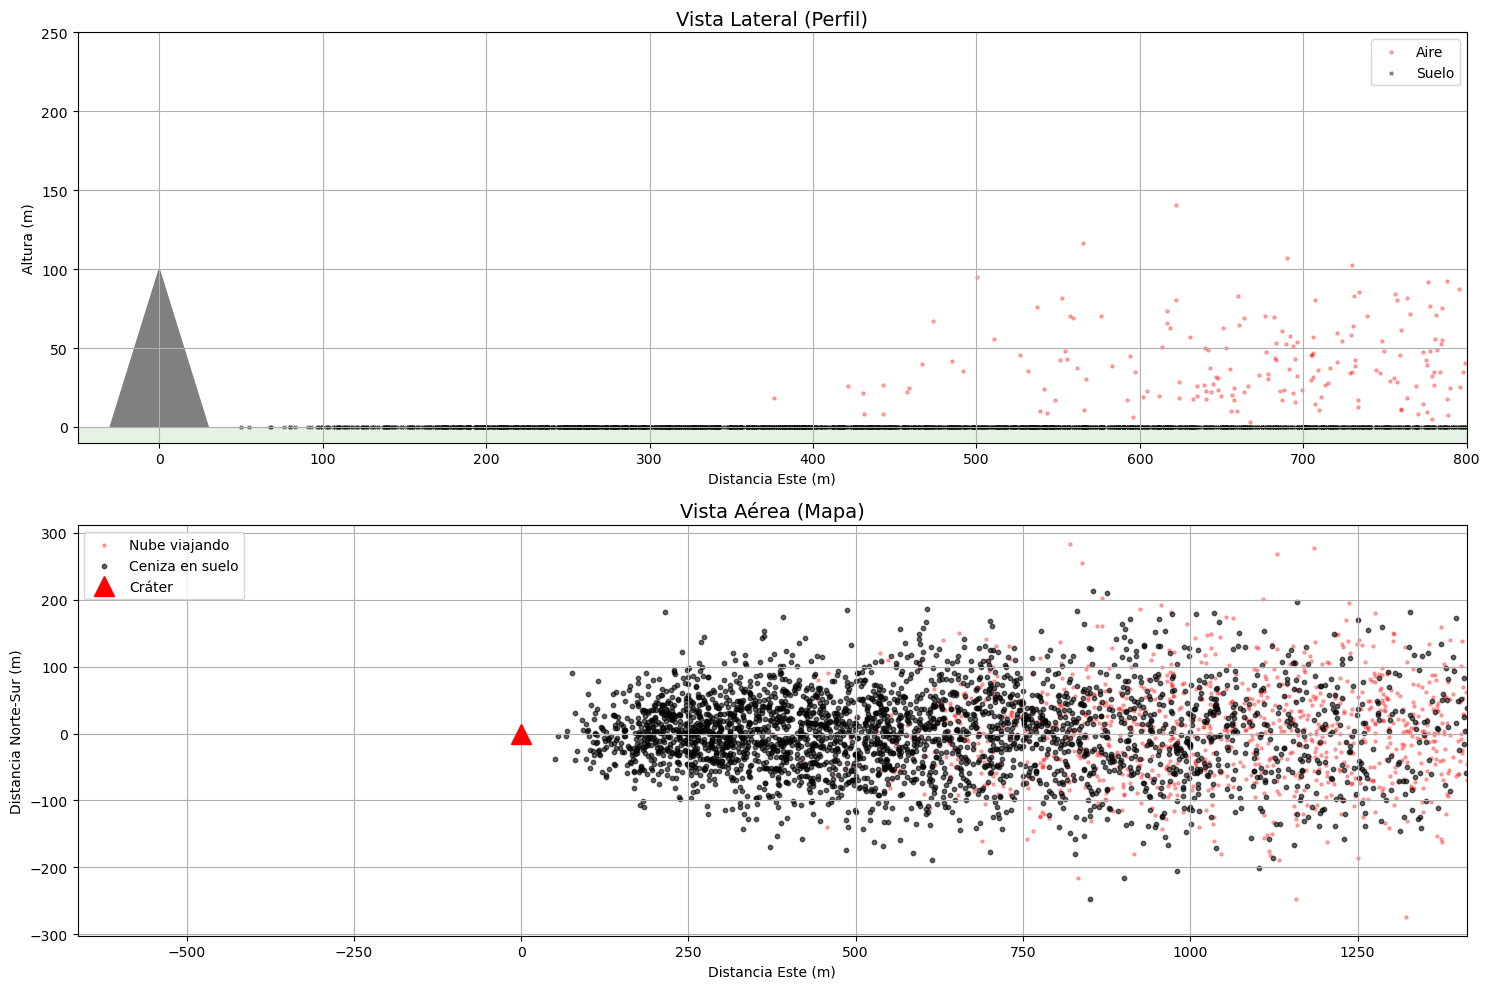

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
N_PARTICULAS = 5000     
DT = 1.0                
TIEMPO_TOTAL = 500     
D = 10.0                

# Datos del Volcán
ALTURA_VOLCAN = 100.0
# NUEVO: Posición en 3D (x=0, y=100, z=0)
POS_VOLCAN = [0.0, ALTURA_VOLCAN, 0.0] 

# --- INICIALIZACIÓN ---
# NUEVO: Array de (N, 3). Columna 0=X, 1=Y, 2=Z
posiciones = np.zeros((N_PARTICULAS, 3)) + POS_VOLCAN
tiempos_nacimiento = np.linspace(0, 300, N_PARTICULAS)
en_suelo = np.zeros(N_PARTICULAS, dtype=bool) 

historial = [] 

# --- FUNCIÓN VIENTO 3D ---
def obtener_viento(pos_array):
    """
    Devuelve el vector de velocidad (vx, vy, vz) para cada partícula.
    """
    alturas = pos_array[:, 1] # Columna 1 es Y (Altura)
    
    # 1. Viento Principal (Eje X - Este)
    # Cizalladura: más fuerte arriba
    vx = 0.05 * alturas 
    
    # 2. Gravedad/Sedimentación (Eje Y - Vertical)
    # Caen constante hacia abajo
    vy = np.full(alturas.shape, -0.3)
    
    # 3. Viento Transversal (Eje Z - Norte/Sur)
    # NUEVO: Asumamos que el viento es puro hacia el Este (z=0), 
    # y que solo la turbulencia dispersará la ceniza a los lados.
    vz = np.zeros(alturas.shape) 
    
    # Devolvemos matriz (N, 3) uniendo las columnas
    return np.column_stack((vx, vy, vz))

# --- BUCLE DE SIMULACIÓN ---
for t_step in range(TIEMPO_TOTAL):
    tiempo_actual = t_step * DT
    
    # Filtros (igual que antes)
    ya_nacieron = tiempos_nacimiento <= tiempo_actual
    activas = ya_nacieron & (~en_suelo)
    
    if np.sum(activas) == 0:
        continue
        
    pos_activas = posiciones[activas]
    
    # --- FÍSICA 3D ---
    # 1. Advección
    viento = obtener_viento(pos_activas) # Ahora devuelve (N, 3)
    
    # 2. Difusión (Ruido en 3D)
    # np.random.normal generará ruido para X, Y y Z automáticamente
    ruido = np.random.normal(0, np.sqrt(2 * D * DT), size=pos_activas.shape)
    
    # 3. Actualizar
    posiciones[activas] += (viento * DT) + ruido
    
    # --- CONDICIONES DE FRONTERA ---
    # Solo miramos Y (columna 1) para el suelo
    nuevos_choques = (posiciones[:, 1] <= 0) & activas
    
    # Corregimos Y a 0
    posiciones[nuevos_choques, 1] = 0.0
    # X y Z se quedan donde cayeron (ahí se queda la ceniza)
    
    en_suelo[nuevos_choques] = True
    
    # Guardamos cada 5 pasos para no llenar la RAM (opcional)
    if t_step % 5 == 0:
        historial.append(posiciones.copy())


# --- VISUALIZACIÓN DOBLE (Panel de Control) ---
plt.figure(figsize=(15, 10))

# Subplot 1: VISTA DE PERFIL (Lo que ya tenías)
# Ejes: X vs Y
plt.subplot(2, 1, 1) # 2 filas, 1 columna, gráfico #1
mask_volando = (tiempos_nacimiento <= (TIEMPO_TOTAL*DT)) & (~en_suelo)
mask_suelo = en_suelo

plt.title("Vista Lateral (Perfil)", fontsize=14)
plt.scatter(posiciones[mask_volando, 0], posiciones[mask_volando, 1], c='red', s=5, alpha=0.3, label='Aire')
plt.scatter(posiciones[mask_suelo, 0], posiciones[mask_suelo, 1], c='black', s=5, alpha=0.5, marker='x', label='Suelo')
plt.fill([-30, 0, 30], [0, ALTURA_VOLCAN, 0], color='gray') # Volcán
plt.axhspan(-20, 0, color='green', alpha=0.1)
plt.ylabel("Altura (m)")
plt.xlabel("Distancia Este (m)")
plt.legend()
plt.grid(True)
plt.ylim(-10, 250)
plt.xlim(-50, 800)


# Subplot 2: VISTA AÉREA / SATÉLITE (NUEVO)
# Ejes: X vs Z (Mirando desde arriba)
plt.subplot(2, 1, 2) # 2 filas, 1 columna, gráfico #2

plt.title("Vista Aérea (Mapa)", fontsize=14)
# Aquí Y no importa, solo vemos dónde cayeron en el plano X-Z
plt.scatter(posiciones[mask_volando, 0], posiciones[mask_volando, 2], c='red', s=5, alpha=0.3, label='Nube viajando')
plt.scatter(posiciones[mask_suelo, 0], posiciones[mask_suelo, 2], c='black', s=10, alpha=0.6, label='Ceniza en suelo')

# Marcamos el volcán como un punto rojo central
plt.plot(0, 0, 'r^', markersize=15, label='Cráter') 

plt.ylabel("Distancia Norte-Sur (m)") # Eje Z
plt.xlabel("Distancia Este (m)")       # Eje X
plt.grid(True)
plt.legend()
plt.axis('equal') # Importante para que el mapa no se vea deforme
plt.xlim(-50, 800)

plt.tight_layout()
plt.show()

In [20]:
# --- EXPERIMENTO: Entendiendo np.histogram2d ---

# 1. Imaginemos 5 partículas que cayeron en estas coordenadas (X, Z)
# Tres cayeron cerca (x=1, z=1)
# Dos cayeron lejos (x=5, z=2)
x_puntos = [1, 1.2, 0.9, 5, 5.1]
z_puntos = [1, 1.1, 0.8, 2, 2.1]

# 2. Creamos una cuadrícula de 5x5 casillas (bins)
# range define el tamaño del terreno: De 0 a 6 metros
heatmap, xedges, yedges = np.histogram2d(x_puntos, z_puntos, bins=5, range=[[0, 6], [0, 6]])

# 3. Veamos la matriz resultante (El mapa de calor numérico)
print("Mapa de conteo (Matriz):")
print(heatmap.T) # Transponemos (.T) para que se lea igual que el gráfico cartesianos

# ¿Qué esperamos ver?
# Deberíamos ver un '3' en una esquina (las 3 partículas cercanas)
# Y un '2' en otro lado.
# El resto ceros.

Mapa de conteo (Matriz):
[[2. 1. 0. 0. 0.]
 [0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


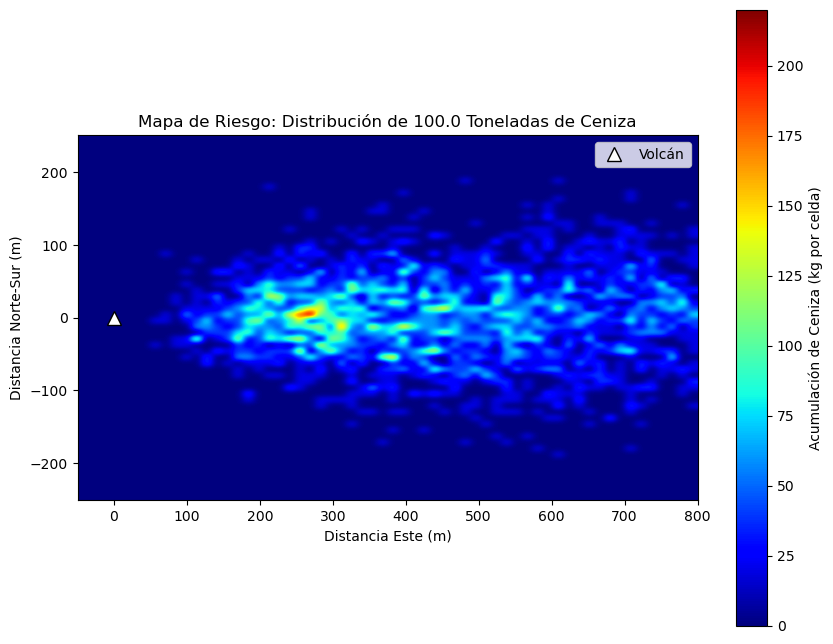

In [21]:
# --- GENERACIÓN DEL MAPA DE RIESGO (POST-PROCESAMIENTO) ---

# 1. Extraer coordenadas SOLO de la ceniza que tocó el suelo
# (Ignoramos la que sigue volando o se fue muy lejos)
x_suelo = posiciones[en_suelo, 0]
z_suelo = posiciones[en_suelo, 2]

# 2. Definir parámetros físicos
MASA_TOTAL_ERUPCION = 100000.0  # Digamos que salieron 100 toneladas (kg)
masa_por_particula = MASA_TOTAL_ERUPCION / N_PARTICULAS

# 3. Crear la Cuadrícula (Binning)
# Definimos el área del mapa que nos interesa ver
rango_x = [-50, 800]   # Largo (Este-Oeste)
rango_z = [-250, 250]  # Ancho (Norte-Sur)
n_bins = 60            # Resolución: 60x60 cuadros

# np.histogram2d cuenta cuántas partículas caen en cada cuadro
conteo, x_bordes, z_bordes = np.histogram2d(
    x_suelo, z_suelo, 
    bins=n_bins, 
    range=[rango_x, rango_z]
)

# 4. Convertir Conteo a Masa (kg)
# Matriz de Masa = (Número de partículas en la celda) * (Peso de c/u)
mapa_masa = conteo * masa_por_particula

# --- VISUALIZACIÓN CIENTÍFICA ---
plt.figure(figsize=(10, 8))

# Usamos imshow para graficar la matriz como una imagen
# .T (Transpuesta): Necesario porque histogram2d devuelve (x,y) pero imshow espera (filas, cols)
# origin='lower': Para que el (0,0) esté abajo a la izquierda, no arriba
# extent: Para ponerle las unidades correctas a los ejes (metros) en lugar de pixeles
# cmap='hot_r': Mapa de color (Hot Reverse). Blanco/Amarillo = Mucha ceniza, Rojo = Media, Negro = Poca.

img = plt.imshow(mapa_masa.T, 
                 interpolation='gaussian', 
                 origin='lower',
                 extent=[rango_x[0], rango_x[1], rango_z[0], rango_z[1]],
                 cmap='jet') # Puedes probar 'hot_r', 'viridis', 'plasma'

plt.colorbar(img, label='Acumulación de Ceniza (kg por celda)')
plt.plot(0, 0, 'w^', markersize=10, markeredgecolor='black', label='Volcán') # Triángulo blanco

plt.title(f"Mapa de Riesgo: Distribución de {MASA_TOTAL_ERUPCION/1000} Toneladas de Ceniza")
plt.xlabel("Distancia Este (m)")
plt.ylabel("Distancia Norte-Sur (m)")
plt.legend()
plt.grid(False) # Quitamos la rejilla para ver mejor los colores
plt.show()

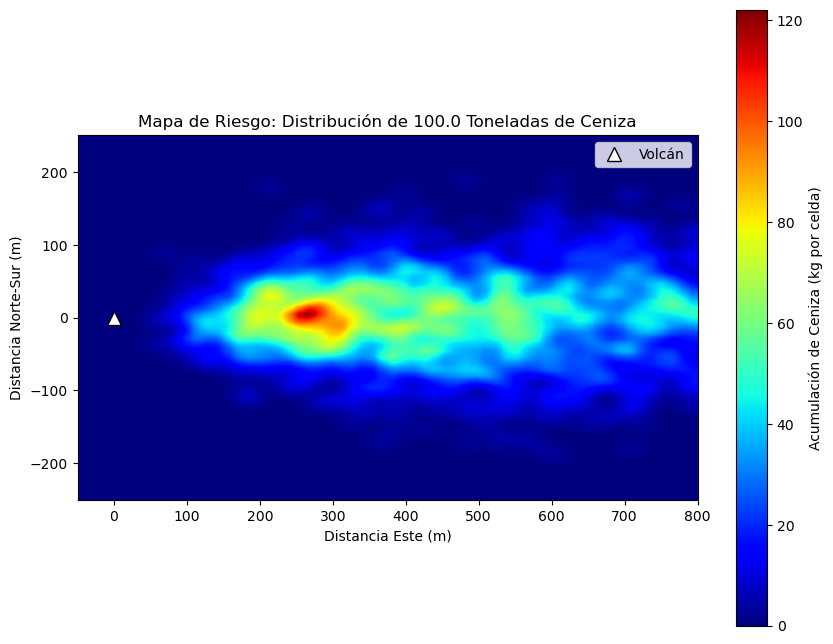

In [22]:

# 1. Extraer coordenadas SOLO de la ceniza que tocó el suelo
# (Ignoramos la que sigue volando o se fue muy lejos)
x_suelo = posiciones[en_suelo, 0]
z_suelo = posiciones[en_suelo, 2]

# 2. Definir parámetros físicos
MASA_TOTAL_ERUPCION = 100000.0  # Digamos que salieron 100 toneladas (kg)
masa_por_particula = MASA_TOTAL_ERUPCION / N_PARTICULAS

# 3. Crear la Cuadrícula (Binning)
# Definimos el área del mapa que nos interesa ver
rango_x = [-50, 800]   # Largo (Este-Oeste)
rango_z = [-250, 250]  # Ancho (Norte-Sur)
n_bins = 60            # Resolución: 60x60 cuadros

# np.histogram2d cuenta cuántas partículas caen en cada cuadro
conteo, x_bordes, z_bordes = np.histogram2d(
    x_suelo, z_suelo, 
    bins=n_bins, 
    range=[rango_x, rango_z]
)

# 4. Convertir Conteo a Masa (kg)
# Matriz de Masa = (Número de partículas en la celda) * (Peso de c/u)
mapa_masa = conteo * masa_por_particula

from scipy.ndimage import gaussian_filter

# ... (código anterior donde calculas mapa_masa) ...

# --- NUEVO: SUAVIZADO ---
# sigma=1 significa "difumina con un radio de 1 pixel vecino"
mapa_suave = gaussian_filter(mapa_masa, sigma=1)

plt.figure(figsize=(10, 8))

# OJO: Ahora graficamos 'mapa_suave' en lugar de 'mapa_masa'
img = plt.imshow(mapa_suave.T, 
                 interpolation='gaussian', 
                 origin='lower',
                 extent=[rango_x[0], rango_x[1], rango_z[0], rango_z[1]],
                 cmap='jet')

# ... (resto del código de títulos y colorbar igual) ...
plt.colorbar(img, label='Acumulación de Ceniza (kg por celda)')
plt.plot(0, 0, 'w^', markersize=10, markeredgecolor='black', label='Volcán') # Triángulo blanco

plt.title(f"Mapa de Riesgo: Distribución de {MASA_TOTAL_ERUPCION/1000} Toneladas de Ceniza")
plt.xlabel("Distancia Este (m)")
plt.ylabel("Distancia Norte-Sur (m)")
plt.legend()
plt.grid(False) # Quitamos la rejilla para ver mejor los colores
plt.show()

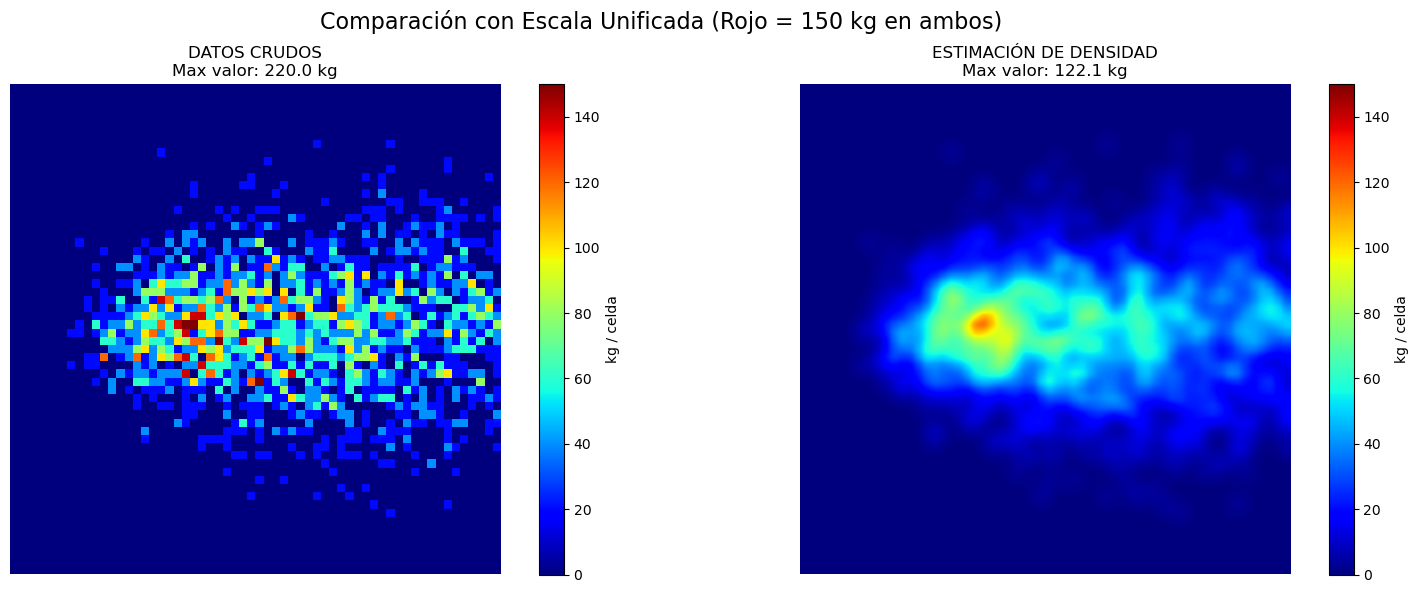

In [23]:
# --- COMPARACIÓN REALISTA (ESCALA FIJA) ---
plt.figure(figsize=(16, 6))

# Definimos el límite de peligro para AMBOS gráficos
LIMITE_MAXIMO = 150  # Rojo intenso siempre será 150 kg/celda

# 1. Mapa Original (Crudo)
plt.subplot(1, 2, 1)
# Agregamos vmin y vmax para fijar la escala
im1 = plt.imshow(mapa_masa.T, origin='lower', cmap='jet', interpolation='nearest',
                 vmin=0, vmax=LIMITE_MAXIMO)
plt.title(f"DATOS CRUDOS\nMax valor: {mapa_masa.max():.1f} kg")
plt.axis('off')
plt.colorbar(im1, label='kg / celda')

# 2. Mapa Filtrado (Suavizado)
plt.subplot(1, 2, 2)
# Usamos EL MISMO vmin y vmax
im2 = plt.imshow(mapa_suave.T, origin='lower', cmap='jet', interpolation='gaussian',
                 vmin=0, vmax=LIMITE_MAXIMO)
plt.title(f"ESTIMACIÓN DE DENSIDAD\nMax valor: {mapa_suave.max():.1f} kg")
plt.axis('off')
plt.colorbar(im2, label='kg / celda')

plt.suptitle("Comparación con Escala Unificada (Rojo = 150 kg en ambos)", fontsize=16)
plt.tight_layout()
plt.show()

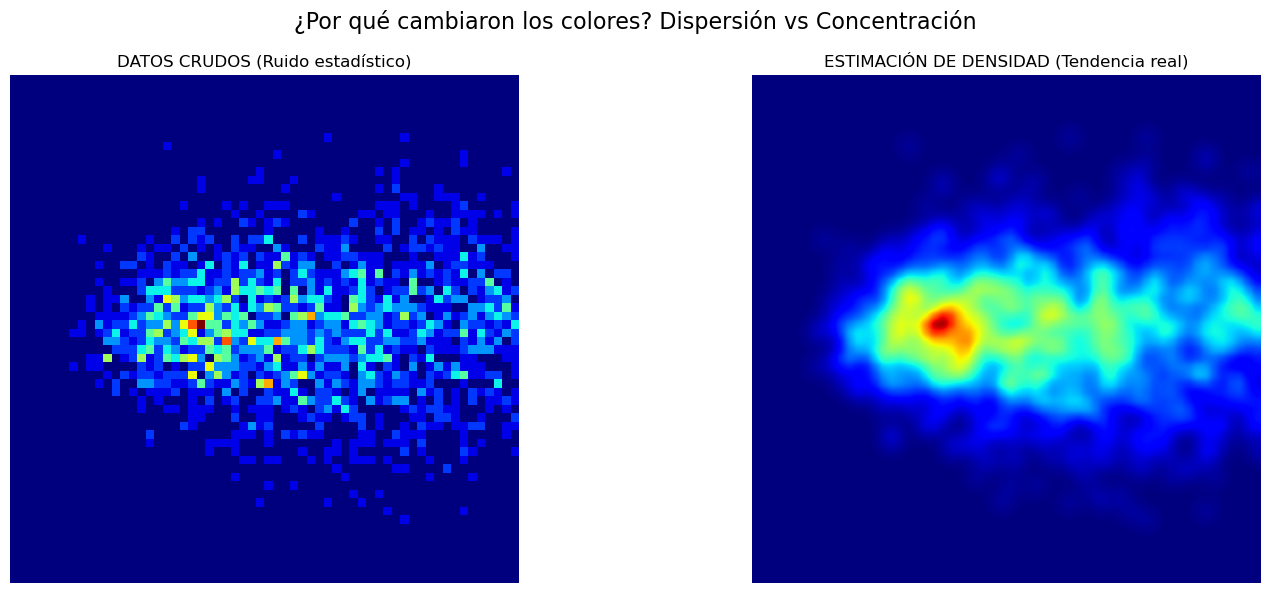

In [24]:
# --- COMPARACIÓN: RAW vs SUAVIZADO ---
plt.figure(figsize=(16, 6))

# 1. Mapa Original (Crudo / Pixelado)
plt.subplot(1, 2, 1)
plt.imshow(mapa_masa.T, origin='lower', cmap='jet', interpolation='nearest')
plt.title("DATOS CRUDOS (Ruido estadístico)")
plt.axis('off') # Quitamos ejes para verlo limpio

# 2. Mapa Filtrado (Suavizado)
plt.subplot(1, 2, 2)
plt.imshow(mapa_suave.T, origin='lower', cmap='jet', interpolation='gaussian')
plt.title("ESTIMACIÓN DE DENSIDAD (Tendencia real)")
plt.axis('off')

plt.suptitle("¿Por qué cambiaron los colores? Dispersión vs Concentración", fontsize=16)
plt.tight_layout()
plt.show()